# Installing and Preparing Environment

**Versions of used packages**

Python Version: *3.10.12*

Joblib Version: *1.3.2*

Numpy Version: *1.23.5*

Pandas Version: *1.5.3*

Datamol: *0.12.2*

RDKit Version: *2023.09.3*

MolVS Version: *0.1.1*

Seaborn Version: *0.12.2*

Matplotlib Version: *3.7.1*

SciPy Version: *1.11.4*

ResReg Version: *0.2*

Scikit-Learn Version: *1.2.2*

DGLLife Version: *0.3.2*

Torch Version: *2.1.0+cu121*

Transformers Version: *4.35.2*

Simpletransformers Version: *0.64.5*

ChemBERTa Version: *ChemBERTa ArXiv paper release*

In [ ]:
# Required packages

!pip install -q resreg
!pip install -q rdkit-pypi
!pip install -q molvs
!pip install -q transformers
!pip install -q simpletransformers
!pip install -q --pre deepchem
!pip install -q regex
!pip install -q dgllife
!pip install -q dgl -f https://data.dgl.ai/wheels/repo.html
!pip install -q datamol

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.7/250.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Required for ChemBerta
import sys
!test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']
!git clone https://github.com/seyonechithrananda/bert-loves-chemistry.git

Cloning into 'bertviz_repo'...
remote: Enumerating objects: 1633, done.
remote: Counting objects: 100% (329/329), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 1633 (delta 231), reused 225 (delta 211), pack-reused 1304
Receiving objects: 100% (1633/1633), 198.37 MiB | 23.30 MiB/s, done.
Resolving deltas: 100% (1073/1073), done.
Cloning into 'bert-loves-chemistry'...
remote: Enumerating objects: 1566, done.
remote: Counting objects: 100% (202/202), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 1566 (delta 96), reused 92 (delta 91), pack-reused 1364
Receiving objects: 100% (1566/1566), 55.35 MiB | 20.65 MiB/s, done.
Resolving deltas: 100% (1000/1000), done.
Updating files: 100% (122/122), done.


In [ ]:
import os
import sys
import glob
from typing import List
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

import resreg
import joblib
from rdkit import Che
from molvs import standardize_smiles
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator

from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

import datamol as dm
from dgllife.model import load_pretrained
from dgl.nn.pytorch.glob import AvgPooling
from dgllife.utils import mol_to_bigraph, PretrainAtomFeaturizer, PretrainBondFeaturizer

import torch
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from transformers import AutoTokenizer, AutoModel

%cd /content/bert-loves-chemistry
from chemberta.utils.molnet_dataloader import load_molnet_dataset, write_molnet_dataset_for_chemprop
%cd ..

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


/content/bert-loves-chemistry
/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# loading dataset

dataset_path = "/content/drive/MyDrive/enzyme_additive_dataset.csv"

df = pd.read_csv(dataset_path, index_col=0)
df = df.drop(df[df["additive_label"] == "M"].index, axis=0).reset_index(drop=True)
print(f"Original number of data: {df.shape[0]}")

Original number of data: 455


In [ ]:
# generated features path

baseline_path = "/content/drive/MyDrive/baseline_features.csv"
chembert_path = "/content/drive/MyDrive/chembert_features.csv"
gin_path = "/content/drive/MyDrive/gin_features.csv"

# 1- Relative Activity Values Standardization

In [ ]:
# A function to standardize relative activity values.

def target_value_standardization(df):

    mean = df.loc[:, "target"].mean()
    std = df.loc[:, "target"].std()
    df["standard_target"] = (df["target"] - mean) / std

    print(f" Relative activity: Mean {mean:.3f} STD {std:.3f}")

    return df

In [ ]:
df = target_value_standardization(df)

 Relative activity: Mean -17.321 STD 71.558


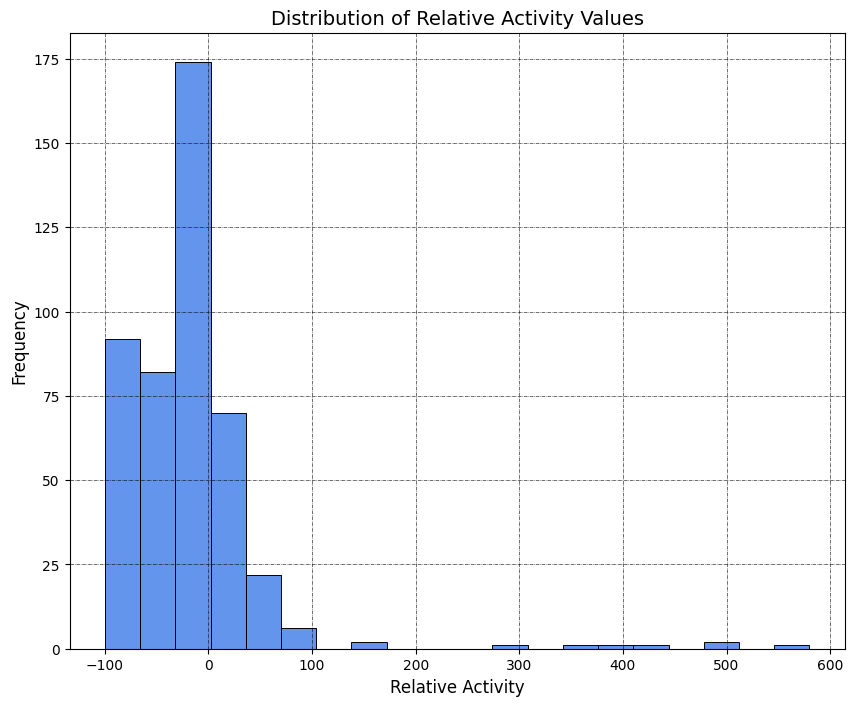

In [ ]:
plt.figure(figsize=(10, 8))
plt.hist(df["target"],
         bins=20,
         color="cornflowerblue",
         edgecolor="black",
         linewidth=0.7)

plt.xlabel("Relative Activity", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Relative Activity Values", fontsize=14)
plt.grid(linestyle='-.', linewidth=0.4, color='black')
plt.savefig("Distribution of Relative Activity Values.png", dpi=300)
plt.show()

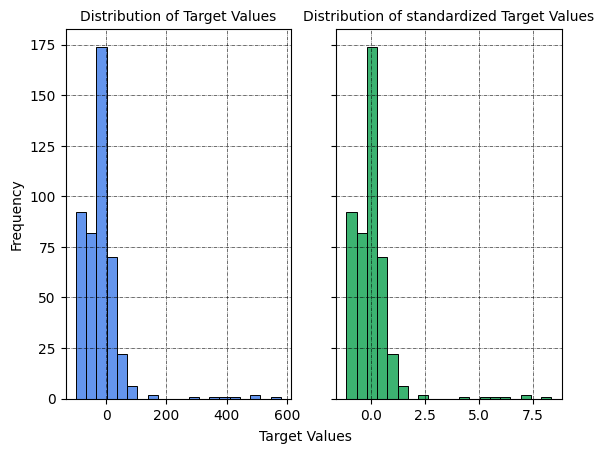

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.hist(df["target"],
         bins=20,
         color='cornflowerblue',
         edgecolor='black',
         linewidth=0.7)

ax2.hist(df["standard_target"],
         bins=20,
         color='mediumseagreen',
         edgecolor='black',
         linewidth=0.7)

ax1.set_title("Distribution of Target Values", fontsize=10)
ax2.set_title("Distribution of standardized Target Values", fontsize=10)
ax1.set_ylabel("Frequency", fontsize=10)

ax1.grid(linestyle='-.', linewidth=0.4, color='black')
ax2.grid(linestyle='-.', linewidth=0.4, color='black')

fig.text(0.5, 0.03, 'Target Values', ha='center', va='center')
plt.savefig("Distribution of (Standardized) Target Values.png", dpi=300)
plt.show()

# 2- Additive Amounts Normalization

In [ ]:
# A function to normalise additive amounts.

def additive_value_normalization(df):

    ml_df1 = df[df["additive_label"] == "mL"]["additive_amount"]
    ml_df1 = ml_df1 / ml_df1.max()

    ml_df2 = df[df["additive_label"] == "mM"]["additive_amount"]
    ml_df2 = ml_df2 / ml_df2.max()

    ml_df3 = df[df["additive_label"] == "%v/v"]["additive_amount"] / 100

    ml_df4 = df[df["additive_label"] == "%w/v"]["additive_amount"] / 100
    ml_df4 = ml_df4 / ml_df4.max()

    concats_df = pd.concat([ml_df1, ml_df2, ml_df3, ml_df4]).sort_index()
    df["additive_amount_normal"] = concats_df

    return df

In [ ]:
df = additive_value_normalization(df)

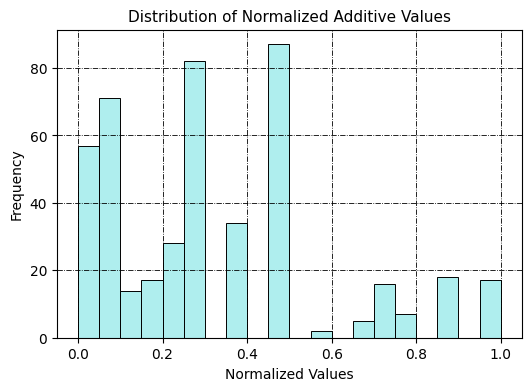

In [ ]:
fig = plt.figure(figsize=(6, 4))
df['additive_amount_normal'].plot.hist(bins=20,
                color='paleturquoise',
                edgecolor='black',
                linewidth=0.7)
plt.grid(linestyle='-.', linewidth=0.6, color='black')
plt.title("Distribution of Normalized Additive Values", size=11)
plt.xlabel("Normalized Values", size=10)
plt.savefig("Distribution of Normalized Additive Values.png", dpi=300)
plt.show()

# 3- Features Generation

In [ ]:
# Generate GIN embeddings

def generate_gin_embeddings(df, smiles_kind, model):

  embeddings_list = []

  for smiles in df.loc[:, smiles_kind].tolist():
    mol = dm.to_mol(smiles)
    bg = mol_to_bigraph(mol,
                      add_self_loop=True,
                      node_featurizer=PretrainAtomFeaturizer(),
                      edge_featurizer=PretrainBondFeaturizer(),
                      canonical_atom_order=False,
                      )
    nfeats = [bg.ndata.pop('atomic_number'),
              bg.ndata.pop('chirality_type')]
    efeats = [bg.edata.pop('bond_type'),
              bg.edata.pop('bond_direction_type')]

    with torch.no_grad():
      node_repr = model(bg, nfeats, efeats)

    embeddings_list.append(AvgPooling()(bg, node_repr).numpy())

  return np.array(embeddings_list).squeeze()

# Generate ChemBerta embeddings

def generate_chemberta_embeddings(df, smiles_kind, model):

  embeddings_list = []

  for smiles in df.loc[:, smiles_kind].tolist():
    inputs = tokenizer(smiles, padding=True, truncation=True, return_tensors='pt', max_length=128)
    with torch.no_grad():
        embeddings = model(**inputs).last_hidden_state[:, 0, :].numpy()
    embeddings_list.append(embeddings)

  return np.array(embeddings_list).squeeze()

# Generate RDKit descriptors

def generate_descriptors(df, mol_kind):

  with open("/content/drive/MyDrive/rdkit_descriptors.txt", "r") as file:
    f = file.read()

  rdkit_descriptors = f.replace("\n", " ").split(", ")
  DescCalc = MolecularDescriptorCalculator(rdkit_descriptors)

  descriptors_list = []

  for mol in df.loc[:, mol_kind].tolist():
    mol_desc = list(DescCalc.CalcDescriptors(mol))
    descriptors_list.append(mol_desc)

  return np.array(descriptors_list)

# Feature generation function. The function uses SMILES of substrate and additive, alongside pH,
# temperature, and EC number. Three different kinds of feature generation techniques are used for
# substrate and additive featurization. Baseline (RDKit descriptors), ChemBert (pre-trained CLM),
# and GIN (pre-trained GNN).

def feature_generator(df, kind, csv):

    pre_feat_df = df.loc[:, ["substrate_smiles", "additive_smiles", "pH", "temp", "ec_number"]]

    pre_feat_df["pH"] = (pre_feat_df["pH"] - pre_feat_df["pH"].mean())/pre_feat_df["pH"].std()
    pre_feat_df["temp"] = (pre_feat_df["temp"] - pre_feat_df["temp"].mean())/pre_feat_df["temp"].std()

    pre_feat_df = pre_feat_df.join(pd.get_dummies(pre_feat_df["ec_number"])).drop("ec_number", axis=1)

    pre_feat_df["substrate_smiles"] = pre_feat_df["substrate_smiles"].apply(standardize_smiles)
    pre_feat_df["additive_smiles"] = pre_feat_df["additive_smiles"].apply(standardize_smiles)

    if kind == "baseline":

        Chem.PandasTools.AddMoleculeColumnToFrame(pre_feat_df, smilesCol="substrate_smiles", molCol="substrate_mol")
        Chem.PandasTools.AddMoleculeColumnToFrame(pre_feat_df, smilesCol="additive_smiles", molCol="additive_mol")

        substrate_features = generate_descriptors(pre_feat_df, "substrate_mol")
        additive_features = generate_descriptors(pre_feat_df, "additive_mol")

        pre_feat_df.drop(["substrate_mol", "additive_mol"], axis=1, inplace=True)

        rest_columns_array = pre_feat_df.iloc[:, 2:].to_numpy()

    elif kind == "chembert":

        tokenizer = AutoTokenizer.from_pretrained('DeepChem/ChemBERTa-77M-MLM');
        chemberta_model = AutoModel.from_pretrained('DeepChem/ChemBERTa-77M-MLM');

        substrate_features = generate_chemberta_embeddings(pre_feat_df, "substrate_smiles", chemberta_model)
        additive_features = generate_chemberta_embeddings(pre_feat_df, "additive_smiles", chemberta_model)

        rest_columns_array = pre_feat_df.iloc[:, 2:].to_numpy()

    elif kind == "gin":

        gin_model = load_pretrained('gin_supervised_masking');

        substrate_features = generate_gin_embeddings(pre_feat_df, "substrate_smiles", gin_model)
        additive_features = generate_gin_embeddings(pre_feat_df, "additive_smiles", gin_model)

        rest_columns_array = pre_feat_df.iloc[:, 2:].to_numpy()

    else:

        assert kind in ["baseline", "chembert", "gin"], "Enter valid kind. Only baseline, chembert, and gin are available."

    feature_vectors = np.hstack((substrate_features, additive_features, rest_columns_array))

    rest_features = pre_feat_df.iloc[:, 2:].columns
    substrate_features = ["sub_" + str(item) for item in range(substrate_features.shape[1])]
    additive_features = ["add_" + str(item) for item in range(additive_features.shape[1])]
    feature_names = [*substrate_features, *additive_features, *rest_features]

    if csv == True:

        pd.DataFrame(data=feature_vectors, columns=feature_names).to_csv(kind + "_features.csv", index=False)

    return feature_vectors, feature_names


In [ ]:
baseline_feature_vectors, baseline_feature_names = feature_generator(df, kind="baseline", csv=True)

In [ ]:
chembert_feature_vectors, chembert_feature_names = feature_generator(df, kind="chembert", csv=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
gin_feature_vectors, gin_feature_names = feature_generator(df, kind="gin", csv=True)

Pretrained model loaded


# 4- Outliers Detection

In [ ]:
# Zscore function for outlier detecttion. If standardize data point (x-mean/std)
# is more than 3, it is selected as outlier. Data point is represented by baseline
# descriptor.

def Zscore_outlier(df):
    out=[]
    m = np.mean(df)
    sd = np.std(df)
    row = 0
    for i in df:
        z = (i-m)/sd
        if np.abs(z) > 3:
            out.append(row)
        row += 1
    return out

In [ ]:
all_outliers = set([*Zscore_outlier(df["target"]), *Zscore_outlier(df["additive_amount_normal"])])

print(f"Indexes of {len(all_outliers)} derived outliers by Zscore:\n")
for outlier in all_outliers:
  print(outlier, end=", ")

Indexes of 7 derived outliers by Zscore:

450, 147, 148, 149, 150, 151, 152, 

# 5- Training

## 5-1- Loading Data

In [ ]:
# A function to make feature vectors, targets, and features name.

def fv_and_label(df1, df2, detected_outliers):

    try:
        df1.drop(list(detected_outliers), axis=0, inplace=True)
        df2.drop(list(detected_outliers), axis=0, inplace=True)
    except:
        pass

    fvs, fns = df1.values, list(df1.columns)
    labels = df2.loc[:, ["standard_target", "additive_amount_normal"]].to_numpy()

    return fvs, labels, fns

In [ ]:
# Baseline features

df = pd.read_csv(dataset_path, index_col=0)
df = df.drop(df[df["additive_label"] == "M"].index, axis=0).reset_index(drop=True)

df = target_value_standardization(df)
df = additive_value_normalization(df)

baseline_features_df = pd.read_csv(baseline_path)
baseline_features_df = baseline_features_df.interpolate()

X_baseline, Y_baseline, baseline_feature_names = fv_and_label(baseline_features_df, df, all_outliers)

print("Baseline features, total number of:")
print(f"Data points: {X_baseline.shape[0]}")
print(f"Target: {Y_baseline.shape[1]}")
print(f"Features: {len(baseline_feature_names)}")

 Relative activity: Mean -17.321 STD 71.558
Baseline features, total number of:
Data points: 448
Target: 2
Features: 448


In [ ]:
# ChemBert features

df = pd.read_csv(dataset_path, index_col=0)
df = df.drop(df[df["additive_label"] == "M"].index, axis=0).reset_index(drop=True)

df = target_value_standardization(df)
df = additive_value_normalization(df)

chembert_features_df = pd.read_csv(chembert_path)

X_chembert, Y_chembert, chembert_feature_names = fv_and_label(chembert_features_df, df, all_outliers)

print("ChemBert features, total number of:")
print(f"Data points: {X_chembert.shape[0]}")
print(f"Target: {Y_chembert.shape[1]}")
print(f"Features: {len(chembert_feature_names)}")

 Relative activity: Mean -17.321 STD 71.558
ChemBert features, total number of:
Data points: 448
Target: 2
Features: 788


In [ ]:
# GIN features

df = pd.read_csv(dataset_path, index_col=0)
df = df.drop(df[df["additive_label"] == "M"].index, axis=0).reset_index(drop=True)

df = target_value_standardization(df)
df = additive_value_normalization(df)

gin_features_df = pd.read_csv(gin_path)

X_gin, Y_gin, gin_feature_names = fv_and_label(gin_features_df, df, all_outliers)

print("GIN features, total number of:")
print(f"Data points: {X_gin.shape[0]}")
print(f"Target: {Y_gin.shape[1]}")
print(f"Features: {len(gin_feature_names)}")

 Relative activity: Mean -17.321 STD 71.558
GIN features, total number of:
Data points: 448
Target: 2
Features: 620


## 5-2- Feature Importance

In [ ]:
# A simple feature importance function based on implemented "Impurity-based Feature
# Importances" in skitlearn RF and ERT algorithms.

def simple_feature_importance(X, Y, feature_names, kind, title):

    if kind == "RF":

      regressor = RandomForestRegressor(n_estimators=100, oob_score=True, n_jobs=-1)
      regressor.fit(X, Y)

    elif kind == "ERT":

      regressor = ExtraTreesRegressor(n_estimators=100, oob_score=True, bootstrap=True, n_jobs=-1)
      regressor.fit(X, Y)

    else:

      assert kind in ["RF", "ERT"], "Enter valid kind. Only RF and ERT are available."



    fi_df = pd.DataFrame({"FN": feature_names, "FI": regressor.feature_importances_ * 100})
    sub_fi = fi_df[fi_df["FN"].str.contains("sub_")]["FI"].sum()
    add_fi = fi_df[fi_df["FN"].str.contains("add_")]["FI"].sum()
    temp_fi = float(fi_df[fi_df["FN"].str.contains("temp")]["FI"])
    ph_fi = float(fi_df[fi_df["FN"].str.match("pH")]["FI"])
    ec_fi = 100 - sub_fi - add_fi - temp_fi - ph_fi

    fi_df.to_csv("FI-" + kind + "-" + title + ".csv", index=False)

    print(f"Feature Importance of {kind} Model Based on {title} Features:\n")
    print(f"Substrate FI: {sub_fi:.3f}%")
    print(f"Additive FI: {add_fi:.3f}%")
    print(f"T FI: {temp_fi:.3f}%")
    print(f"pH FI: {ph_fi:.3f}%")
    print(f"EC number FI: {ec_fi:.3f}%")

    return fi_df

In [ ]:
_ = simple_feature_importance(X_baseline, Y_baseline, baseline_feature_names, "RF", "Baseline")

Feature Importance of RF Model Based on Baseline Features:

Substrate FI: 29.703%
Additive FI: 38.089%
T FI: 10.789%
pH FI: 10.774%
EC number FI: 10.644%


In [ ]:
_ = simple_feature_importance(X_baseline, Y_baseline, baseline_feature_names, "ERT", "Baseline")

Feature Importance of ERT Model Based on Baseline Features:

Substrate FI: 28.940%
Additive FI: 38.602%
T FI: 9.430%
pH FI: 9.431%
EC number FI: 13.596%


## 5-3 Training Randomized Split

In [ ]:
# Relative activity mean and std

MEAN = -17.321
STD =  71.558
SPLIT_NUMBER = 31

In [ ]:
# Calculate four metrics. root mean square error (RMSE), mean absolute of error (MAE),
#coefficient of determination (R2), and Pearson's correlation coefficient (RP). Return
# a dictionary of metrics.

def metrics_results(Y, Y_pred, results):

  rmse = metrics.mean_squared_error(Y, Y_pred, squared=False)
  rmse1, rmse2 = metrics.mean_squared_error(Y, Y_pred, squared=False, multioutput="raw_values")

  mae = metrics.mean_absolute_error(Y, Y_pred)
  mae1, mae2 = metrics.mean_absolute_error(Y, Y_pred, multioutput="raw_values")

  r2score = metrics.r2_score(Y, Y_pred)
  r2score1, r2score2 = metrics.r2_score(Y, Y_pred, multioutput="raw_values")

  rp1 = stats.pearsonr(Y[:, 0], Y_pred[:, 0]).statistic
  rp2 = stats.pearsonr(Y[:, 1], Y_pred[:, 1]).statistic

  results["rmse"].append(rmse)
  results["rmse1"].append(rmse1)
  results["rmse2"].append(rmse2)

  results["mae"].append(mae)
  results["mae1"].append(mae1)
  results["mae2"].append(mae2)

  results["r2score"].append(r2score)
  results["r2score1"].append(r2score1)
  results["r2score2"].append(r2score2)

  results["rp1"].append(rp1)
  results["rp2"].append(rp2)

  return results


In [ ]:
# Training and testing is conducted based on 200 different randomized train-test (9:1) split.
# Both RF and ERT are used as learning algorithms. random_state variable is set from 1 to 200
# for both train-test split and regressor. Function returns results for both test set and OOB.

def training_and_testing(X, Y, mean, std, total_number, method, feature_generation_name):

  test_results = defaultdict(list)
  oob_results = defaultdict(list)
  Y_preds = {}

  for random_number in range(1, total_number, 1):

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=random_number)

    if method == "RF":
      regressor = RandomForestRegressor(n_estimators=100, oob_score=True, n_jobs=-1, random_state=random_number)

    elif method == "ERT":
      regressor = ExtraTreesRegressor(n_estimators=100, oob_score=True, bootstrap=True, n_jobs=-1, random_state=random_number)

    else:
      assert method in ["RF", "ERT"], "Enter valid method. Only RF and ERT are available."

    regressor.fit(X_train, Y_train)

    joblib.dump(regressor, f"{method}_{feature_generation_name}_{random_number}.joblib")

    Y_pred = regressor.predict(X_test)
    Y_oob = regressor.oob_prediction_

    Y_train[:, 0] = Y_train[:, 0] * STD + MEAN
    Y_test[:, 0] = Y_test[:, 0] * STD + MEAN
    Y_pred[:, 0] = Y_pred[:, 0] * STD + MEAN
    Y_oob[:, 0] = Y_oob[:, 0] * STD + MEAN

    _ = metrics_results(Y_test, Y_pred, test_results)
    _ = metrics_results(Y_train, Y_oob, oob_results)

    Y_preds[str(random_number)] = Y_pred

  return test_results, oob_results, Y_preds


In [ ]:
# Plotting results for all metrics. 1 means Relative Activity (RA) and 2 means
# Additive aMount (AM).

def plot_results(results, title):

  df = pd.DataFrame(results)
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))

  ax1 = sns.boxplot(df.iloc[:, :6], linewidth=1.5, ax=ax1)
  ax1.set_xticklabels(["RMSE", "RMSE(RA)", "RMSE(AM)", "MAE", "MAE(RA)", "MAE(AM)"])
  ax1.grid(linestyle='-.', linewidth=0.4, color='black')
  ax1.set_xlabel("Metrics", fontsize=13)

  ax2 = sns.boxplot(df.iloc[:, 6:], linewidth=1.5, ax=ax2)
  ax2.set_xticklabels(["$R^{2}$", "$R^{2}$(RA)", "$R^{2}$(AM)", "$R_{P}$(RA)", "$R_{P}$(AM)"])
  ax2.set(ylim=(0, 1))
  ax2.grid(linestyle='-.', linewidth=0.4, color='black')
  ax2.set_xlabel("Metrics", fontsize=13)

  fig.suptitle(title, fontsize=14)
  plt.savefig(title + ".png", dpi=300)
  plt.tight_layout()
  plt.show()

In [ ]:
# Save each train-test split results to csv. Only Y_preds of test set are saved.

def y_pred_to_csv(Y_pred, total_number, filename):

  for item in range(1, total_number, 1):
    pd.DataFrame(Y_pred[str(item)]).to_csv(f"{filename}_{item}.csv", index=False)


### 5-3-1- Baseline

In [ ]:
rf_baseline_test_results, rf_baseline_oob_results, rf_baseline_Y_pred_test = training_and_testing(X_baseline, Y_baseline, MEAN, STD, SPLIT_NUMBER, "RF", "Baseline")
ert_baseline_test_results, ert_baseline_oob_results, ert_baseline_Y_pred_test = training_and_testing(X_baseline, Y_baseline, MEAN, STD, SPLIT_NUMBER, "ERT", "Baseline")

In [ ]:
y_pred_to_csv(rf_baseline_Y_pred_test, SPLIT_NUMBER, "rf_baseline_Y_pred_test")
y_pred_to_csv(ert_baseline_Y_pred_test, SPLIT_NUMBER, "ert_baseline_Y_pred_test")

In [ ]:
for item in zip([rf_baseline_test_results, rf_baseline_oob_results, ert_baseline_test_results, ert_baseline_oob_results],
    ["rf_baseline_test_results", "rf_baseline_oob_results", "ert_baseline_test_results", "ert_baseline_oob_results"]):

  pd.DataFrame(item[0]).to_csv(str(item[1]) + ".csv", index = False)
  pd.DataFrame(item[0]).describe().to_csv("statistics_" + str(item[1]) + ".csv", index=True)

### 5-3-2- Chembert

In [ ]:
rf_chembert_test_results, rf_chembert_oob_results, rf_chembert_Y_pred_test = training_and_testing(X_chembert, Y_chembert, MEAN, STD, SPLIT_NUMBER, "RF", "Chembert")
ert_chembert_test_results, ert_chembert_oob_results, ert_chembert_Y_pred_test = training_and_testing(X_chembert, Y_chembert, MEAN, STD, SPLIT_NUMBER, "ERT", "Chembert")

In [ ]:
y_pred_to_csv(rf_chembert_Y_pred_test, SPLIT_NUMBER, "rf_chembert_Y_pred_test")
y_pred_to_csv(ert_chembert_Y_pred_test, SPLIT_NUMBER, "ert_chembert_Y_pred_test")

In [ ]:
for item in zip([rf_chembert_test_results, rf_chembert_oob_results, ert_chembert_test_results, ert_chembert_oob_results],
    ["rf_chembert_test_results", "rf_chembert_oob_results", "ert_chembert_test_results", "ert_chembert_oob_results"]):

    pd.DataFrame(item[0]).to_csv(str(item[1]) + ".csv", index = False)
    pd.DataFrame(item[0]).describe().to_csv("statistics_" + str(item[1]) + ".csv", index=True)

### 5-3-3- GIN

In [ ]:
rf_gin_test_results, rf_gin_oob_results, rf_gin_Y_pred_test = training_and_testing(X_gin, Y_gin, MEAN, STD, SPLIT_NUMBER, "RF", "GIN")
ert_gin_test_results, ert_gin_oob_results, ert_gin_Y_pred_test = training_and_testing(X_gin, Y_gin, MEAN, STD, SPLIT_NUMBER, "ERT", "GIN")

In [ ]:
y_pred_to_csv(rf_gin_Y_pred_test, SPLIT_NUMBER, "rf_gin_Y_pred_test")
y_pred_to_csv(ert_gin_Y_pred_test, SPLIT_NUMBER, "ert_gin_Y_pred_test")

In [ ]:
for item in zip([rf_gin_test_results, rf_gin_oob_results, ert_gin_test_results, ert_gin_oob_results],
    ["rf_gin_test_results", "rf_gin_oob_results", "ert_gin_test_results", "ert_gin_oob_results"]):

    pd.DataFrame(item[0]).to_csv(str(item[1]) + ".csv", index = False)
    pd.DataFrame(item[0]).describe().to_csv("statistics_" + str(item[1]) + ".csv", index=True)

### 5-3-4 Ensembling

In [ ]:
# Ensemble all predicted values of test set to make a robust model.

def ensemble_results(X, Y, split_number, MEAN, STD):

  _, _, _, Y_test = train_test_split(X, Y, test_size=0.1, random_state=split_number)

  Y_test[:, 0] = Y_test[:, 0] * STD + MEAN

  Y_pred_sum = 0
  csv_files = glob.glob(f"*_{split_number}.csv")

  for csv_file in csv_files:

    Y_pred_df = pd.read_csv(csv_file)
    Y_pred_sum += Y_pred_df

  Y_pred_mean = Y_pred_sum / len(csv_files)

  results = defaultdict(list)
  results = metrics_results(Y_test, Y_pred_mean.values, results)

  return results

In [ ]:
ens_df = pd.DataFrame()

for split_number in range(1, SPLIT_NUMBER, 1):

  ensemble_metrics = ensemble_results(X_baseline, Y_baseline, split_number, MEAN, STD)
  ens_df = pd.concat([pd.DataFrame(ensemble_metrics), ens_df])
  ens_df.reset_index(drop=True, inplace=True)

ens_df.to_csv("ensemble_results.csv", index = False)
ens_df.describe().to_csv("statistics_ensemble_results.csv", index=True)

### 5-3-5 Comparison

In [ ]:
# Comparison of all metrics of all model.

def plot_comparison(metric, title):

  results_metrics_df = pd.concat([rf_baseline_metrics_df.loc[:, metric],
                                  ert_baseline_metrics_df.loc[:, metric],
                                  rf_chembert_metrics_df.loc[:, metric],
                                  ert_chembert_metrics_df.loc[:, metric],
                                  rf_gin_metrics_df.loc[:, metric],
                                  ert_gin_metrics_df.loc[:, metric],
                                  ensemble_metrics_df.loc[:, metric]
                                  ],
                                 axis=1)

  results_metrics_df.columns = name_color.keys()

  plt.figure(figsize=(10, 8))
  sns.boxplot(results_metrics_df, palette=name_color, linewidth=1.5)
  plt.xlabel("Model", fontsize=12)
  plt.ylabel(title, fontsize=12)
  plt.grid(linestyle='-.', linewidth=0.4, color='black')
  plt.savefig(f"{title}-Comparison.png", dpi=300)
  plt.show()


In [ ]:
ert_baseline_metrics_df = pd.read_csv("ert_baseline_test_results.csv")
rf_baseline_metrics_df = pd.read_csv("rf_baseline_test_results.csv")
ert_chembert_metrics_df = pd.read_csv("ert_chembert_test_results.csv")
rf_chembert_metrics_df = pd.read_csv("rf_chembert_test_results.csv")
ert_gin_metrics_df = pd.read_csv("ert_gin_test_results.csv")
rf_gin_metrics_df = pd.read_csv("rf_gin_test_results.csv")
ensemble_metrics_df = pd.read_csv("ensemble_results.csv")

In [ ]:
name_color = {"RF-Baseline": "lightskyblue",
              "ERT-Baseline": "deepskyblue",
              "RF-Chembert": "tomato",
              "ERT-Chembert": "crimson",
              "RF-GIN": "lightgreen",
              "ERT-GIN": "forestgreen",
              "Ensemble": "mediumslateblue"}

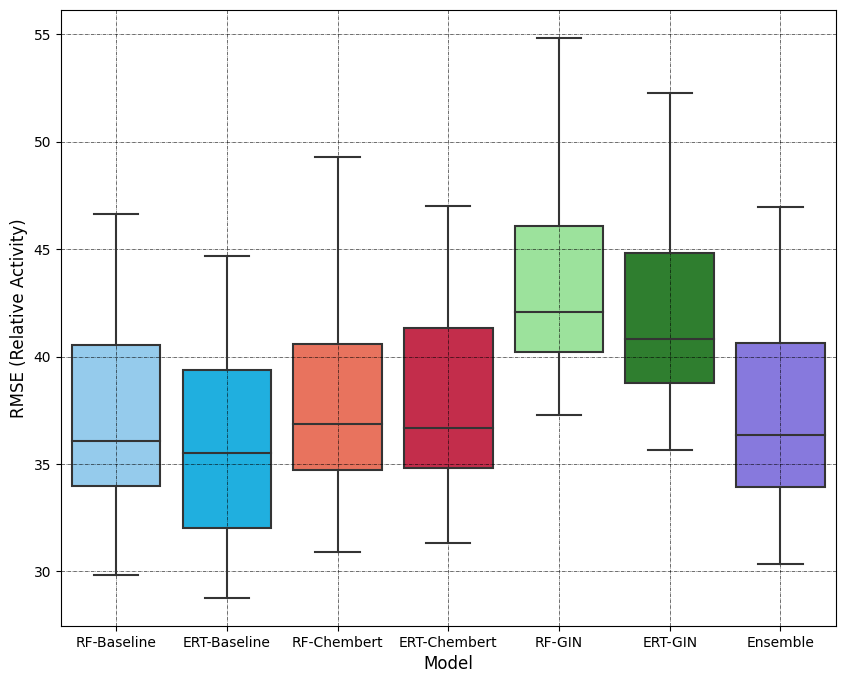

In [ ]:
plot_comparison("rmse1", "RMSE (Relative Activity)")

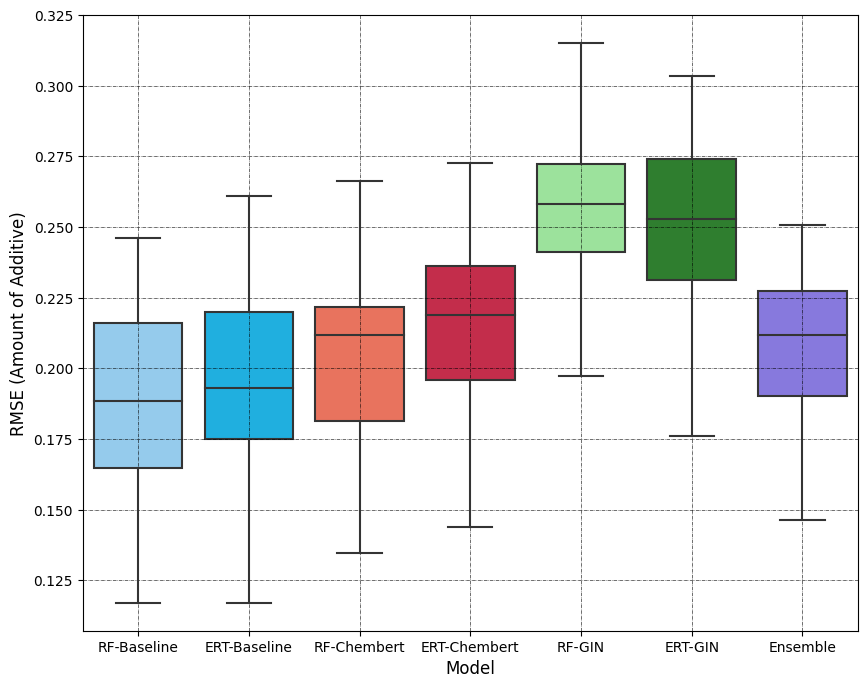

In [ ]:
plot_comparison("rmse2", "RMSE (Amount of Additive)")

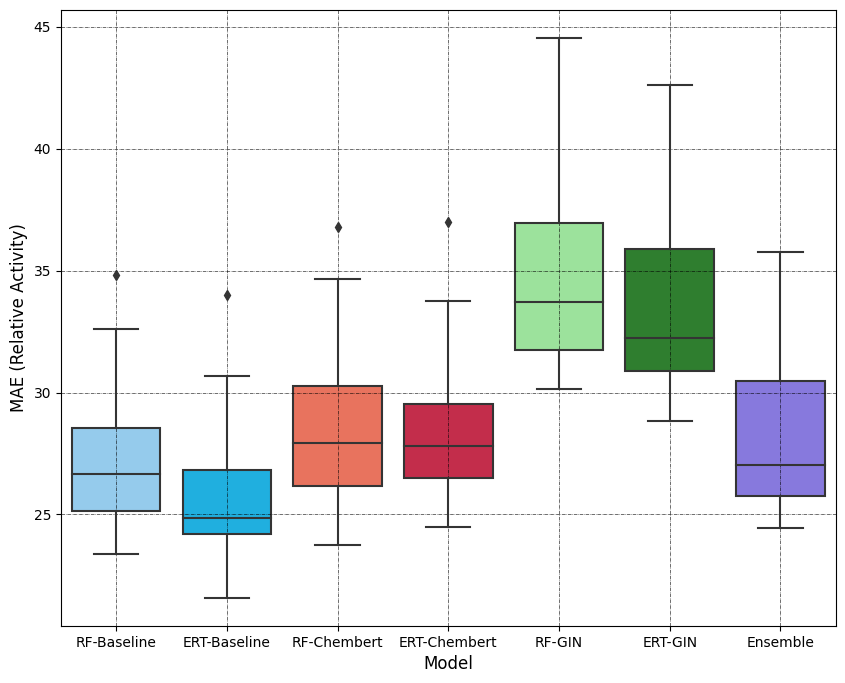

In [ ]:
plot_comparison("mae1", "MAE (Relative Activity)")

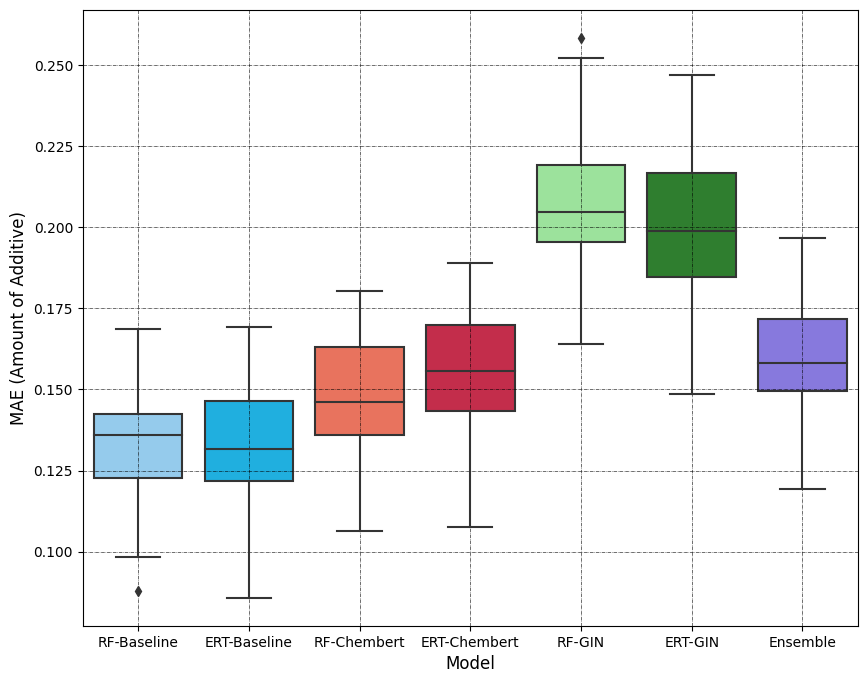

In [ ]:
plot_comparison("mae2", "MAE (Amount of Additive)")

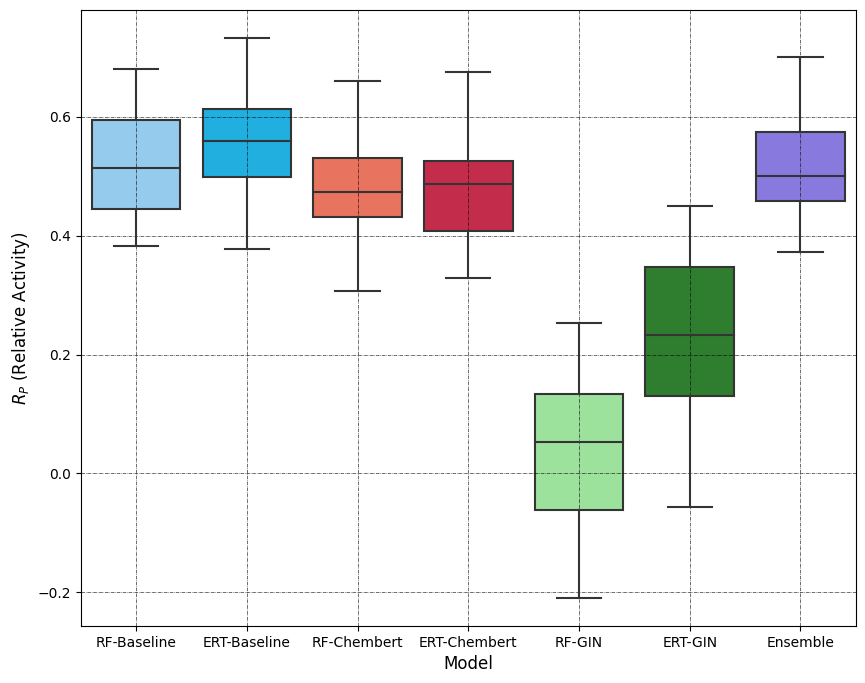

In [ ]:
plot_comparison("rp1", "$R_{P}$ (Relative Activity)")

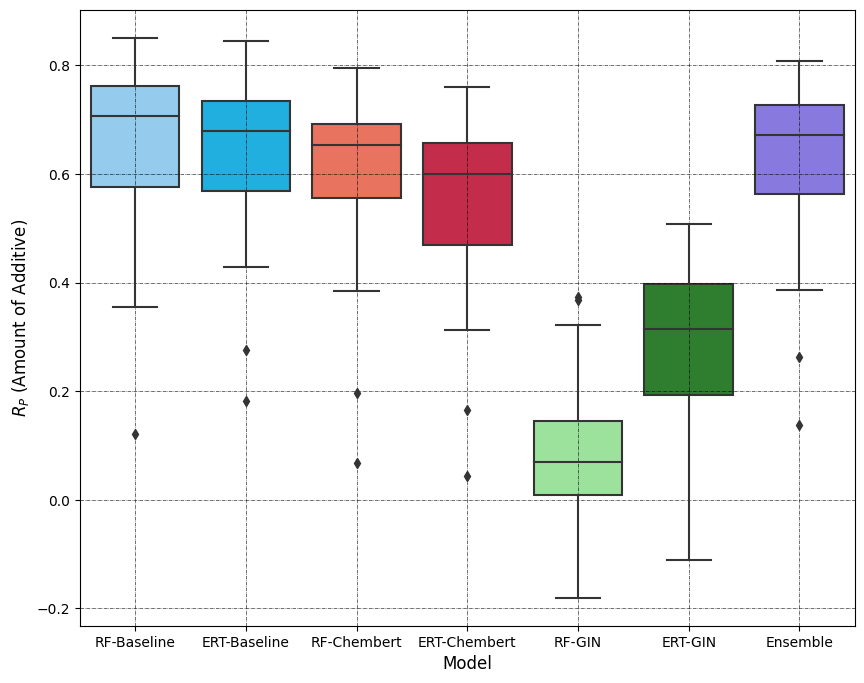

In [ ]:
plot_comparison("rp2", "$R_{P}$ (Amount of Additive)")

## 5-4- Training with Resampling

In [ ]:
# Training and testing with oversampling method. We use oversampling because number of data with negative relative activity
# are larger than positive ones. We are applying "balance" method here.

def training_and_testing_with_resampling(X, Y, mean, std, percentile, sampling_method, total_number, method, feature_generation_name):

  test_results = defaultdict(list)
  oob_results = defaultdict(list)
  Y_preds = {}

  for random_number in range(1, total_number, 1):

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=random_number)

    relevance = resreg.sigmoid_relevance(Y_train, cl=None, ch=percentile)
    X_train, Y_train = resreg.random_oversample(X_train ,Y_train, relevance, relevance_threshold=0.5, over=sampling_method, random_state=random_number)

    if method == "RF":
      regressor = RandomForestRegressor(n_estimators=100, oob_score=True, n_jobs=-1, random_state=random_number)

    elif method == "ERT":
      regressor = ExtraTreesRegressor(n_estimators=100, oob_score=True, bootstrap=True, n_jobs=-1, random_state=random_number)

    else:
      assert method in ["RF", "ERT"], "Enter valid method. Only RF and ERT are available."

    regressor.fit(X_train, Y_train)

    joblib.dump(regressor, f"{method}_Balance_{feature_generation_name}_{random_number}.joblib")

    Y_pred = regressor.predict(X_test)
    Y_oob = regressor.oob_prediction_

    Y_train[:, 0] = Y_train[:, 0] * STD + MEAN
    Y_test[:, 0] = Y_test[:, 0] * STD + MEAN
    Y_pred[:, 0] = Y_pred[:, 0] * STD + MEAN
    Y_oob[:, 0] = Y_oob[:, 0] * STD + MEAN

    _ = metrics_results(Y_test, Y_pred, test_results)
    _ = metrics_results(Y_train, Y_oob, oob_results)

    Y_preds[str(random_number)] = Y_pred

  return test_results, oob_results, Y_preds

In [ ]:
# 80th percentile as a threhold to differentiate rare and normal domain.

PERCENTILE = np.percentile(Y_baseline[:, 0], 80)
print(f"80th percentile: {PERCENTILE:.3f}")

80th percentile: 0.313


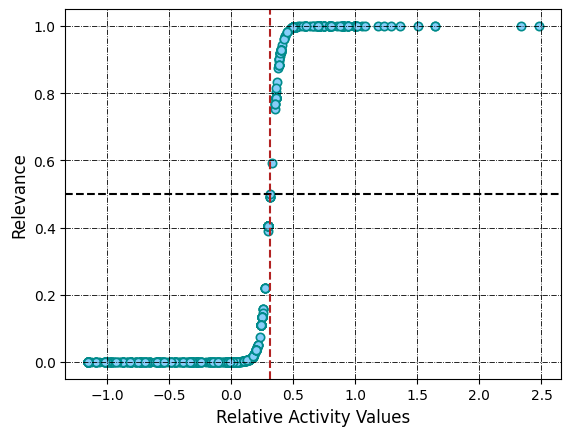

In [ ]:
# Sigmoid function as a relevance function.

relevance = resreg.sigmoid_relevance(Y_baseline, cl=None, ch=PERCENTILE)
plt.scatter(Y_baseline, relevance, c="lightskyblue", edgecolor="darkcyan", linewidths=1.2)
plt.axhline(0.5, linestyle='--', color='black')
plt.axvline(PERCENTILE, linestyle='--', color='firebrick')
plt.xlabel('Relative Activity Values', fontsize=12)
plt.ylabel('Relevance', fontsize=12)
plt.grid(linestyle='-.', linewidth=0.6, color='black')
plt.savefig("Relevance-Plot.png", dpi=300)
plt.show()

### 5-4-1 Baseline

In [ ]:
rf_baseline_test_results, rf_baseline_oob_results, rf_baseline_Y_pred_test = training_and_testing_with_resampling(X_baseline,
                                                                                                                  Y_baseline,
                                                                                                                  MEAN,
                                                                                                                  STD,
                                                                                                                  PERCENTILE,
                                                                                                                  "balance",
                                                                                                                  SPLIT_NUMBER,
                                                                                                                  "RF",
                                                                                                                  "Baseline")
ert_baseline_test_results, ert_baseline_oob_results, ert_baseline_Y_pred_test = training_and_testing_with_resampling(X_baseline,
                                                                                                                  Y_baseline,
                                                                                                                  MEAN,
                                                                                                                  STD,
                                                                                                                  PERCENTILE,
                                                                                                                  "balance",
                                                                                                                  SPLIT_NUMBER,
                                                                                                                  "ERT",
                                                                                                                  "Baseline")

In [ ]:
y_pred_to_csv(rf_baseline_Y_pred_test, SPLIT_NUMBER, "rf_baseline_Y_pred_test_balance")
y_pred_to_csv(ert_baseline_Y_pred_test, SPLIT_NUMBER, "ert_baseline_Y_pred_test_balance")

In [ ]:
for item in zip([rf_baseline_test_results, rf_baseline_oob_results, ert_baseline_test_results, ert_baseline_oob_results],
    ["rf_baseline_test_results_balance", "rf_baseline_oob_results_balance", "ert_baseline_test_results_balance", "ert_baseline_oob_results_balance"]):

  pd.DataFrame(item[0]).to_csv(str(item[1]) + ".csv", index = False)
  pd.DataFrame(item[0]).describe().to_csv("statistics_" + str(item[1]) + ".csv", index=True)

### 5-4-2- Chembert

In [ ]:
rf_chembert_test_results, rf_chembert_oob_results, rf_chembert_Y_pred_test = training_and_testing_with_resampling(X_chembert,
                                                                                                                  Y_chembert,
                                                                                                                  MEAN,
                                                                                                                  STD,
                                                                                                                  PERCENTILE,
                                                                                                                  "balance",
                                                                                                                  SPLIT_NUMBER,
                                                                                                                  "RF",
                                                                                                                  "Chembert")
ert_chembert_test_results, ert_chembert_oob_results, ert_chembert_Y_pred_test = training_and_testing_with_resampling(X_chembert,
                                                                                                                  Y_chembert,
                                                                                                                  MEAN,
                                                                                                                  STD,
                                                                                                                  PERCENTILE,
                                                                                                                  "balance",
                                                                                                                  SPLIT_NUMBER,
                                                                                                                  "ERT",
                                                                                                                  "Chembert")

In [ ]:
y_pred_to_csv(rf_chembert_Y_pred_test, SPLIT_NUMBER, "rf_chembert_Y_pred_test_balance")
y_pred_to_csv(ert_chembert_Y_pred_test, SPLIT_NUMBER, "ert_chembert_Y_pred_test_balance")

In [ ]:
for item in zip([rf_chembert_test_results, rf_chembert_oob_results, ert_chembert_test_results, ert_chembert_oob_results],
    ["rf_chembert_test_results_balance", "rf_chembert_oob_results_balance", "ert_chembert_test_results_balance", "ert_chembert_oob_results_balance"]):

    pd.DataFrame(item[0]).to_csv(str(item[1]) + ".csv", index = False)
    pd.DataFrame(item[0]).describe().to_csv("statistics_" + str(item[1]) + ".csv", index=True)

### 5-4-3- GIN

In [ ]:
rf_gin_test_results, rf_gin_oob_results, rf_gin_Y_pred_test = training_and_testing_with_resampling(X_gin,
                                                                                                  Y_gin,
                                                                                                  MEAN,
                                                                                                  STD,
                                                                                                  PERCENTILE,
                                                                                                  "balance",
                                                                                                  SPLIT_NUMBER,
                                                                                                  "RF",
                                                                                                  "GIN")
ert_gin_test_results, ert_gin_oob_results, ert_gin_Y_pred_test = training_and_testing_with_resampling(X_gin,
                                                                                                      Y_gin,
                                                                                                      MEAN,
                                                                                                      STD,
                                                                                                      PERCENTILE,
                                                                                                      "balance",
                                                                                                      SPLIT_NUMBER,
                                                                                                      "ERT",
                                                                                                      "GIN")

In [ ]:
y_pred_to_csv(rf_gin_Y_pred_test, SPLIT_NUMBER, "rf_gin_Y_pred_test_balance")
y_pred_to_csv(ert_gin_Y_pred_test, SPLIT_NUMBER, "ert_gin_Y_pred_test_balance")

In [ ]:
for item in zip([rf_gin_test_results, rf_gin_oob_results, ert_gin_test_results, ert_gin_oob_results],
    ["rf_gin_test_results_balance", "rf_gin_oob_results_balance", "ert_gin_test_results_balance", "ert_gin_oob_results_balance"]):

    pd.DataFrame(item[0]).to_csv(str(item[1]) + ".csv", index = False)
    pd.DataFrame(item[0]).describe().to_csv("statistics_" + str(item[1]) + ".csv", index=True)

### 5-4-4- Ensembling

In [ ]:
# Ensemble all predicted values of test set to make a robust model.

def ensemble_results(X, Y, split_number, MEAN, STD):

  _, _, _, Y_test = train_test_split(X, Y, test_size=0.1, random_state=split_number)

  Y_test[:, 0] = Y_test[:, 0] * STD + MEAN

  Y_pred_sum = 0
  csv_files = glob.glob(f"*_{split_number}.csv")

  for csv_file in csv_files:

    Y_pred_df = pd.read_csv(csv_file)
    Y_pred_sum += Y_pred_df

  Y_pred_mean = Y_pred_sum / len(csv_files)

  results = defaultdict(list)
  results = metrics_results(Y_test, Y_pred_mean.values, results)

  return results

In [ ]:
ens_df = pd.DataFrame()

for split_number in range(1, SPLIT_NUMBER, 1):

  ensemble_metrics = ensemble_results(X_baseline, Y_baseline, split_number, MEAN, STD)
  ens_df = pd.concat([pd.DataFrame(ensemble_metrics), ens_df])
  ens_df.reset_index(drop=True, inplace=True)

  ens_df.to_csv("ensemble_results_balance.csv", index = False)
  ens_df.describe().to_csv("statistics_ensemble_results_balance.csv", index=True)


### 5-4-5 Comparison

In [ ]:
ert_baseline_metrics_df = pd.read_csv("ert_baseline_test_results_balance.csv")
rf_baseline_metrics_df = pd.read_csv("rf_baseline_test_results_balance.csv")
ert_chembert_metrics_df = pd.read_csv("ert_chembert_test_results_balance.csv")
rf_chembert_metrics_df = pd.read_csv("rf_chembert_test_results_balance.csv")
ert_gin_metrics_df = pd.read_csv("ert_gin_test_results_balance.csv")
rf_gin_metrics_df = pd.read_csv("rf_gin_test_results_balance.csv")
ensemble_metrics_df = pd.read_csv("ensemble_results_balance.csv")

In [ ]:
name_color = {"RF-Baseline": "lightskyblue",
              "ERT-Baseline": "deepskyblue",
              "RF-Chembert": "tomato",
              "ERT-Chembert": "crimson",
              "RF-GIN": "lightgreen",
              "ERT-GIN": "forestgreen",
              "Ensemble": "mediumslateblue"}

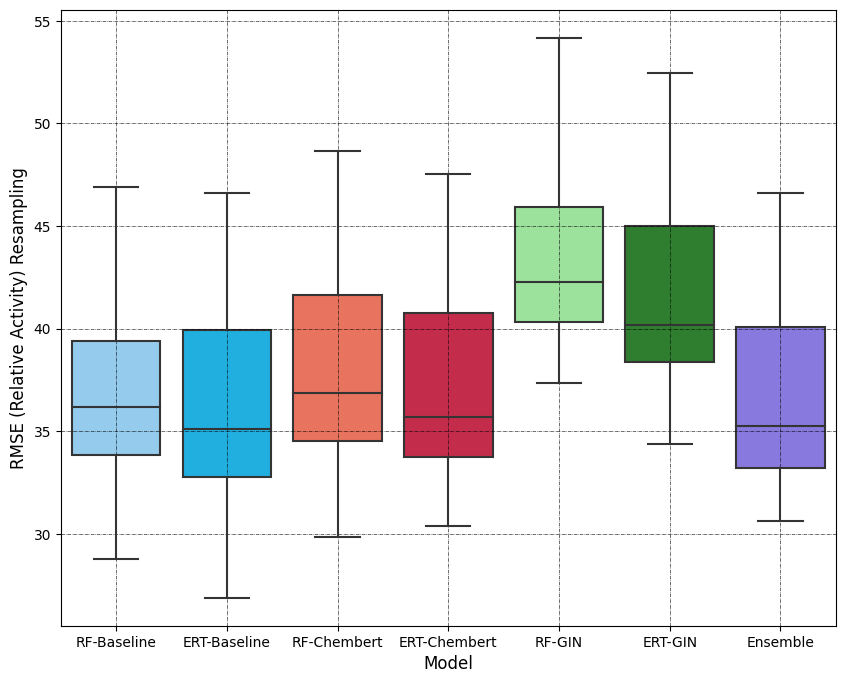

In [ ]:
plot_comparison("rmse1", "RMSE (Relative Activity) Resampling")

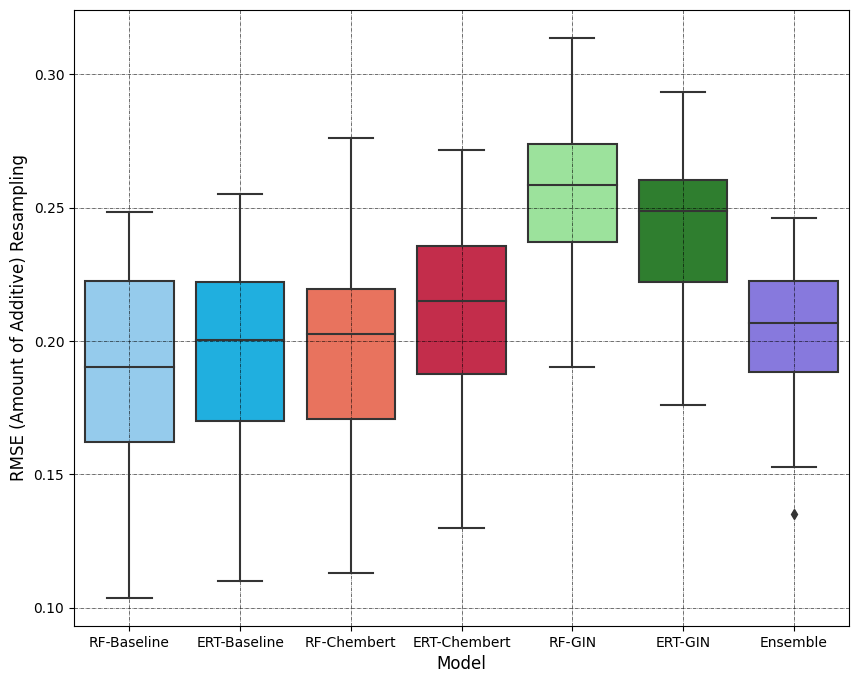

In [ ]:
plot_comparison("rmse2", "RMSE (Amount of Additive) Resampling")

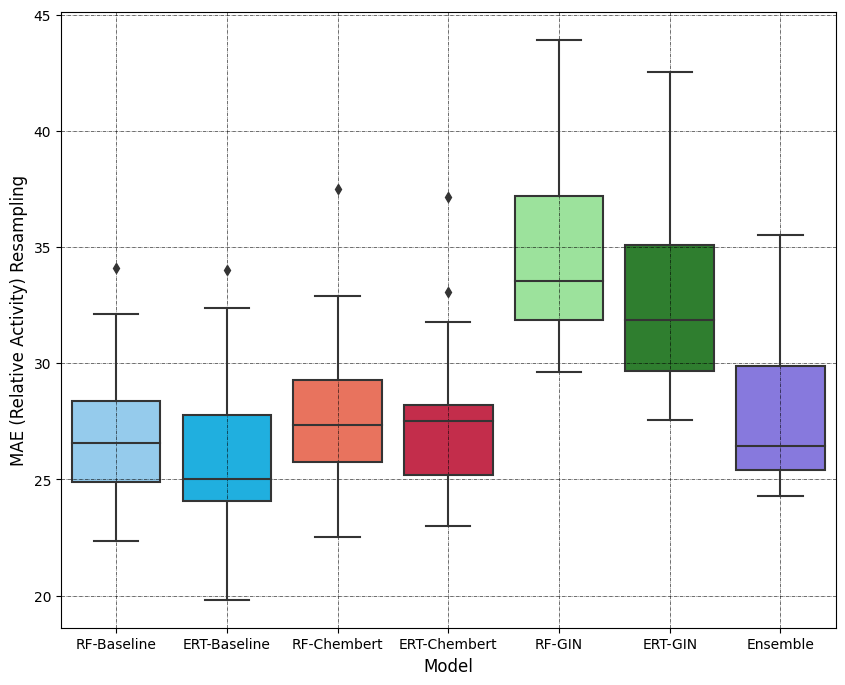

In [ ]:
plot_comparison("mae1", "MAE (Relative Activity) Resampling")

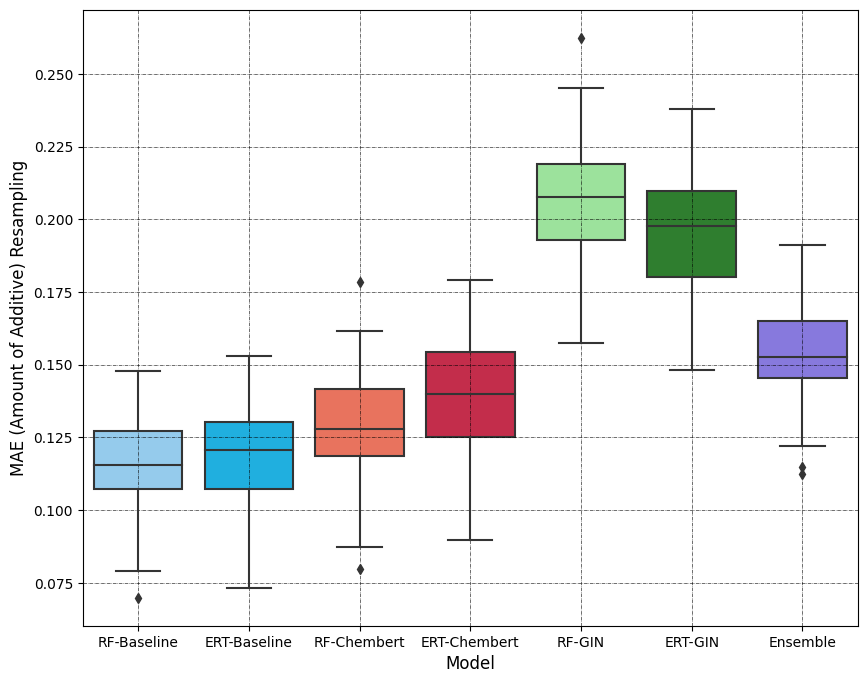

In [ ]:
plot_comparison("mae2", "MAE (Amount of Additive) Resampling")

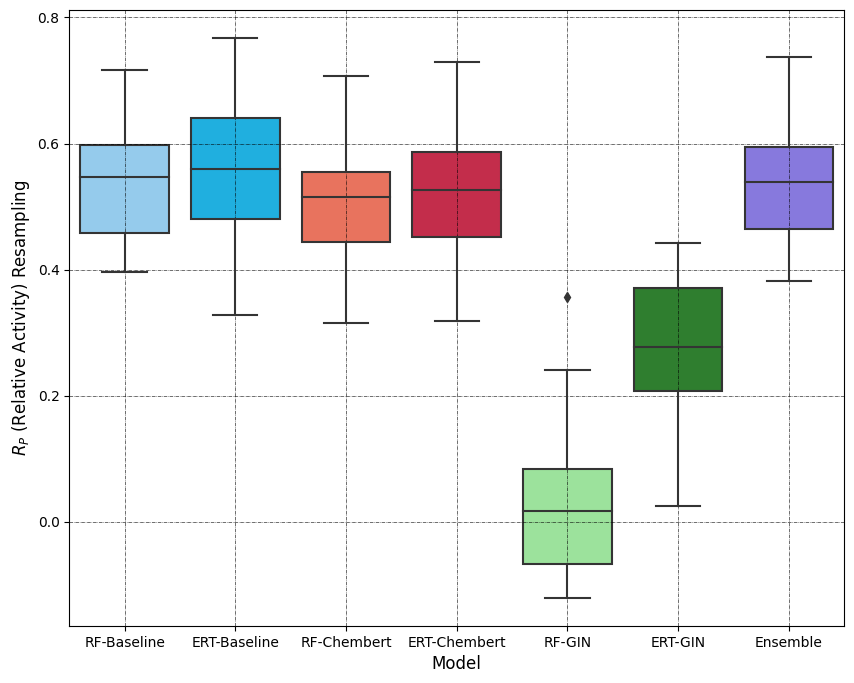

In [ ]:
plot_comparison("rp1", "$R_{P}$ (Relative Activity) Resampling")

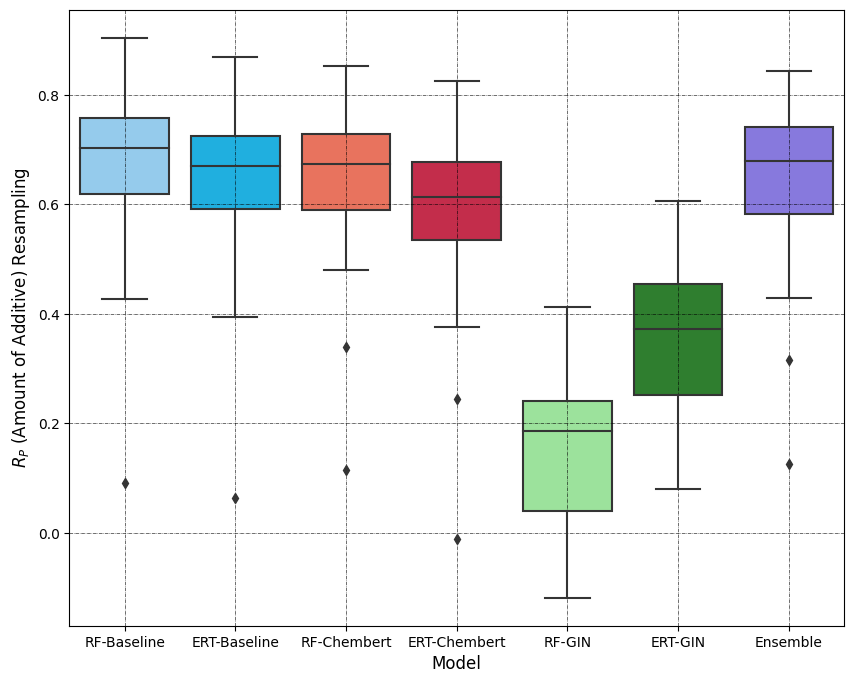

In [ ]:
plot_comparison("rp2", "$R_{P}$ (Amount of Additive) Resampling")

## 5-5- Save Results

In [ ]:
# Zip all files except folder
!zip -r results.zip *.*

  adding: $R_{P}$ (Amount of Additive)-Comparison.png (deflated 35%)
  adding: $R_{P}$ (Amount of Additive) Resampling-Comparison.png (deflated 34%)
  adding: $R_{P}$ (Relative Activity)-Comparison.png (deflated 38%)
  adding: $R_{P}$ (Relative Activity) Resampling-Comparison.png (deflated 36%)
  adding: Distribution of Normalized Additive Values.png (deflated 24%)
  adding: Distribution of Relative Activity Values.png (deflated 43%)
  adding: Distribution of (Standardized) Target Values.png (deflated 29%)
  adding: Ensemble - Balance - Test Set.png (deflated 36%)
  adding: ensemble_results_balance.csv (deflated 49%)
  adding: ensemble_results.csv (deflated 49%)
  adding: Ensemble - Test Set.png (deflated 37%)
  adding: ERT_Balance_Baseline_10.joblib (deflated 65%)
  adding: ERT_Balance_Baseline_11.joblib (deflated 65%)
  adding: ERT_Balance_Baseline_12.joblib (deflated 65%)
  adding: ERT_Balance_Baseline_13.joblib (deflated 65%)
  adding: ERT_Balance_Baseline_14.joblib (deflated 65%)


## 5-6- ADDZYME

In [ ]:
%%writefile addzyme_gui.py

import glob
import joblib
import numpy as np
import streamlit as st
from molvs import standardize_smiles
from rdkit.Chem import Descriptors, MolFromSmiles
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator

st.set_page_config(
    page_title="ADDZYME GUI",
    page_icon="./title_logo.png",
    layout="centered",
    initial_sidebar_state="collapsed",
)

#Title

st.title("ADDZYME")
st.header("Additive Effects on Enzyme Activity Predictor")
st.write("**ADDZYME** is software for predicting effect of an additive on an enzyme activity.")

#Sidebar

st.sidebar.header("About")
st.sidebar.image("./github_logo.png", width=30)
st.sidebar.write("[GitHub](https://github.com/miladrayka), Developed by *[Milad Rayka](https://scholar.google.com/citations?user=NxF2f0cAAAAJ&hl=en)*.")
st.sidebar.divider()
st.sidebar.write("""**ADDZYME** is a software for predicting effect of an additive on an enzyme activity. It is developed at
*Baqiyatallah University of Medical Sciences*.""")
st.sidebar.divider()
st.sidebar.write("""**Reference**:\n
Paper is *under production.*""")

#Body

with st.expander("See Information"):
    st.write("""**ADDZYME** is a machine learning-based algorithm for prediction of the effect of an additive on the activity of
                an enzyme. It uses 30 ERT-Baseline models to report relative activity
                For more information refer to our published paper.""")


substrate_smiles = st.text_input("Enter SMILES of the substrate:",
                                placeholder="C1=CC=C(C=C1)C=O",
                                help="Use [PubChem](https://pubchem.ncbi.nlm.nih.gov/) for finding SMILES ")
if substrate_smiles:

    try:
        standard_substrate_smiles = standardize_smiles(substrate_smiles)
        substrate_molwt = Descriptors.MolWt(MolFromSmiles(standard_substrate_smiles))

        substrate_min_weight, substrate_max_weight = 120.063, 399.092

        if (substrate_molwt >= substrate_min_weight) & (substrate_molwt <= substrate_max_weight):
            st.success("Substrate is indomain.")
        else:
            st.warning(f"Substrate is outdomain. Molecular weight of substrate should be between {substrate_min_weight} and {substrate_max_weight}")

    except:
        assert substrate_smiles == None, "Enter valid SMILES. See the help."



additive_smiles = st.text_input("Enter SMILES of the additive:",
                                placeholder="C1=CC=C(C=C1)C=O",
                                help="Use [PubChem](https://pubchem.ncbi.nlm.nih.gov/) for finding SMILES ")

if additive_smiles:

    try:
        standard_additive_smiles = standardize_smiles(additive_smiles)
        additive_molwt = Descriptors.MolWt(MolFromSmiles(standard_additive_smiles))

        additive_min_weight, additive_max_weight = 28.010, 276.116

        if (additive_molwt >= additive_min_weight) & (additive_molwt <= additive_max_weight):
            st.success("Additive is indomain.")
        else:
            st.warning(f"Additive is outdomain. Molecular weight of additive should be between {additive_min_weight} and {additive_max_weight}")

    except:
        assert additive_smiles == None, "Enter valid SMILES. See the help."


ec_number = ['3.1.1.1',
             '3.1.1.13',
             '3.1.1.2',
             '3.1.1.20',
             '3.1.1.25',
             '3.1.1.3',
             '3.1.1.43',
             '3.1.1.5',
             '3.1.1.59',
             '3.1.1.6',
             '3.1.1.60',
             '3.1.1.74',
             '3.1.1.79',
             '3.1.1.81',
             '3.1.3.12',
             '3.1.3.2',
             '3.1.4.46',
             '3.1.8.1',]

ec_number_index = dict(zip(ec_number, range(0, 18)))
one_hot = [0] * 18

selected_ec_number = st.selectbox("Select EC Number:", ec_number, help="Select one of the following EC number.")

if selected_ec_number:

    one_hot[ec_number_index[selected_ec_number]] = 1

temp = st.slider("Enter temperature:", min_value=20, max_value=75, step=5, help="Temperature applicability of domain is between 20 and 75.")
pH = st.slider("Enter pH:", min_value=5.0, max_value=9.0, step=0.5, help="pH applicability of domain is between 5 and 9.")

TEMP_MEAN, TEMP_STD = 37.769, 14.533
PH_MEAN, PH_STD =  7.519, 0.903

if temp:
    standard_temp = temp * TEMP_STD + TEMP_MEAN

if pH:
    standard_pH = pH * PH_STD + PH_MEAN

start = st.button("Predict Activity Status")

def load_and_predict(models, fv):

    predicted_values = []

    for model in models:

        reg = joblib.load(model)
        predicted_value = reg.predict(fv)
        predicted_values.append(predicted_value)

    return predicted_values

if start:

    with st.spinner("Please Wait..."):

        with open("./rdkit_descriptors.txt", "r") as file:
          f = file.read()

        rdkit_descriptors = f.replace("\n", " ").split(", ")
        DescCalc = MolecularDescriptorCalculator(rdkit_descriptors)

        substrate_mol = MolFromSmiles(standard_substrate_smiles)
        additive_mol = MolFromSmiles(standard_additive_smiles)

        substrate_desc = list(DescCalc.CalcDescriptors(substrate_mol))
        additive_desc = list(DescCalc.CalcDescriptors(additive_mol))

        baseline_fv = np.concatenate([substrate_desc, additive_desc, [standard_pH, standard_temp, *one_hot]])

        baseline_models = glob.glob(r".\models\ERT_Baseline_*.joblib")

        baseline_predicted_values = load_and_predict(baseline_models, baseline_fv.reshape(1, -1))

        l1 = np.array(baseline_predicted_values).reshape(30, 2)

        RA_MEAN = -17.321
        RA_STD =  71.558

        final_prediction = l1[:, 0] * RA_STD + RA_MEAN

        positive_cases = sum(final_prediction > 5)
        negative_cases = sum(final_prediction < -5)
        neutral_cases = sum((final_prediction >= -5) & (final_prediction <= 5))

        st.success(f"{positive_cases} cases of 30 model predict increase in activity.")
        st.success(f"{negative_cases} cases of 30 model predict decrase in activity.")
        st.success(f"{neutral_cases} cases of 30 model predict no change in activity.")